<a href="https://colab.research.google.com/github/soorajpu12/LSTproject/blob/master/emissivity_from_DN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parts taken from- https://geohackweek.github.io/raster/04-workingwithrasters/

In [1]:
pip install rasterio

In [2]:
pip install pyproj

In [3]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 13)

Populating the interactive namespace from numpy and matplotlib


1) CONVERSION TO **TOA BRIGHTNESS TEMPERATURE**

Decimation factor= 9


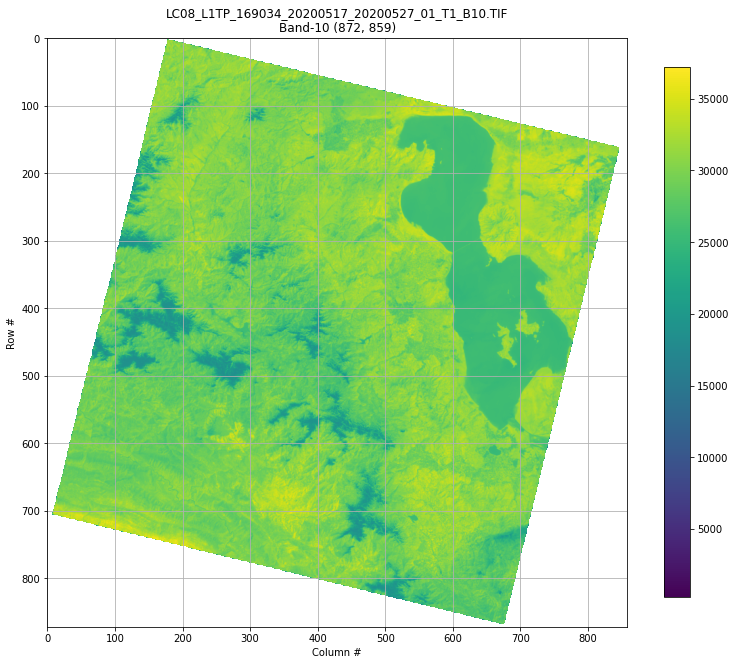

In [5]:
# Upload band 10 to get brightness temperature

date = '2020-05-17'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/169/034/LC08_L1TP_169034_20200517_20200527_01_T1/'
dn_band = 'LC08_L1TP_169034_20200517_20200527_01_T1_B{}.TIF'.format(10)

with rasterio.open(url+dn_band) as src1:
    profile = src1.profile
    oviews = src1.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    dnn = src1.read(1, out_shape=(1, int(src1.height // oview), int(src1.width // oview)))
    #############################################
    # remove border
    dnnb = dnn.astype('f4')
    dnnb[dnnb==0] = np.nan

    #############################################

plt.imshow(dnnb)
plt.colorbar(shrink=0.75)
plt.title('{}\nBand-10 {}'.format(dn_band, dnn.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()

In [6]:
def DN_to_BrightnessTemp(image, M , A , k1, k2):     
    
    TOA_radiance = np.zeros(image.shape)
    brightness_temp = np.zeros(image.shape)        
    TOA_radiance = (M * image) + A
    # The minus 273.15 below is so as to obtain the result in degree celcius
    brightness_temp = (k2 / (np.log((k1 / TOA_radiance) + 1))) - 273.15
    return brightness_temp

OLI and TIRS band data can be converted to TOA Spectral Radiance using Radiance rescaling factors in the metadata file

[TXT FILE URL](http://landsat-pds.s3.amazonaws.com/c1/L8/169/034/LC08_L1TP_169034_20200517_20200527_01_T1/LC08_L1TP_169034_20200517_20200527_01_T1_MTL.txt)


    # M = Band-specific multiplicative rescaling factor from the image folder metadata (RADIANCE_MULT_BAND_x, where x is the band number).
    # A = Band-specific additive rescaling factor from the image folder metadata (RADIANCE_ADD_BAND_x, where x is the band number).
    # k1 = Band-specific thermal conversion constant from the image folder metadata (K1_CONSTANT_BAND_x, where x is the thermal band number)
    # k2 = Band-specific thermal conversion constant from the image folder metadata (K2_CONSTANT_BAND_x, where x is the thermal band number

In [7]:
# Input values manually from MTL.txt file
image = dnnb
M = 3.3420E-04
A = 0.10000
k1 = 774.8853 
k2 = 1321.0789

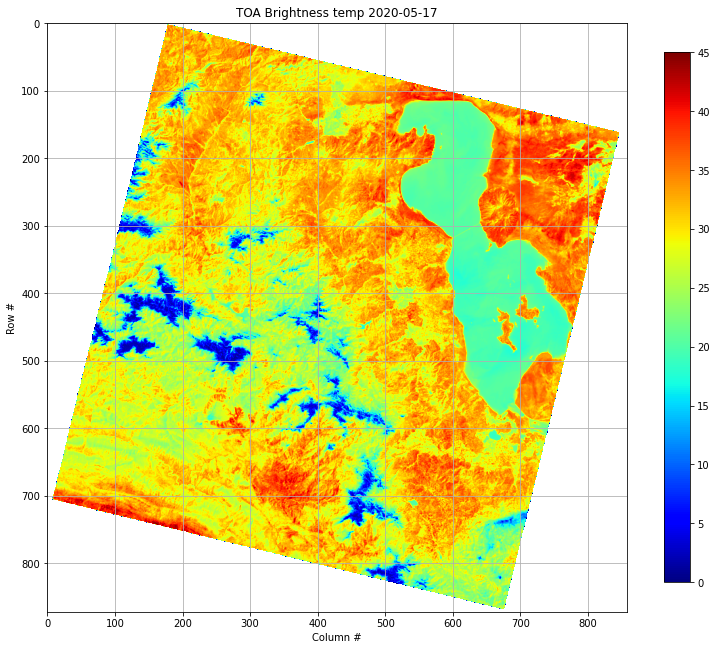

In [8]:
dn1 = DN_to_BrightnessTemp(image, M , A , k1, k2)
dn1 = dn1.astype('f4')
dn1[dn1==0] = np.nan
plt.imshow(dn1, cmap='jet')
plt.colorbar(shrink=0.75)
plt.title('TOA Brightness temp {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(0,45)

2) FINDING **NDVI**

Decimation factor= 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


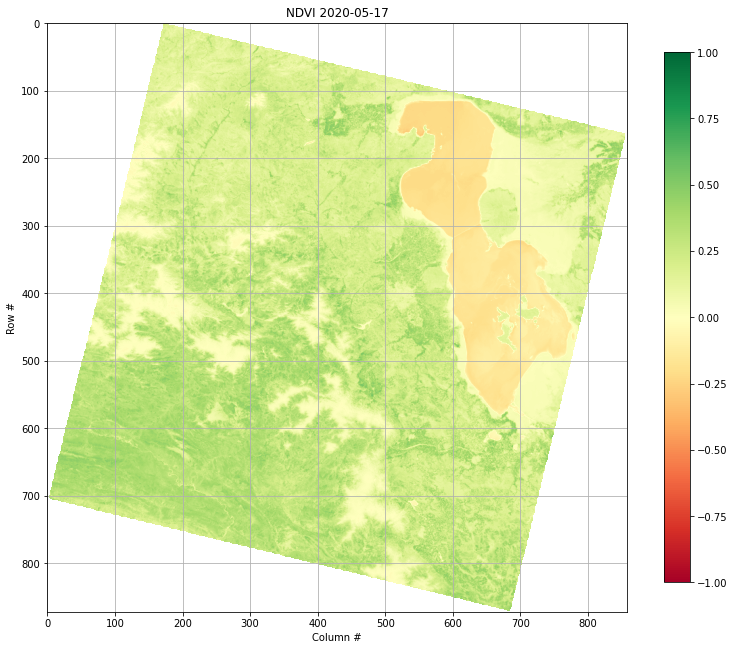

In [9]:
# Image- lake Urmia, Iran
date = '2020-05-17'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/169/034/LC08_L1TP_169034_20200517_20200527_01_T1/'
redband = 'LC08_L1TP_169034_20200517_20200527_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_169034_20200517_20200527_01_T1_B{}.TIF'.format(5)

#######################################################################################

with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

# plt.imshow(red)
# plt.colorbar(shrink=0.75)
# plt.title('{}\nRed {}'.format(redband, red.shape))
# plt.xlabel('Column #')
# plt.ylabel('Row #')
# matplotlib.pyplot.grid()

#######################################################################################

with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

# plt.imshow(nir)
# plt.colorbar(shrink=0.75)
# plt.title('{}\nNIR {}'.format(nirband, nir.shape))
# plt.xlabel('Column #')
# plt.ylabel('Row #')
# matplotlib.pyplot.grid()

#######################################################################################

def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(shrink=0.75)
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(-1,1)

3) FINDING **EMISSIVITY**

In [10]:
def emmissivity_NDVI_threshold_TIR10(NDVI, mask):
        emissivity = np.zeros(NDVI.shape) 
        # Set values in emissivity matrix based on NDVI matrix value with same index
        mask1 = NDVI < 0.2
        mask2 = NDVI > 0.5
        mask3 = (NDVI >= 0.2) & (NDVI <= 0.5)

        i1, j1 = np.where(mask1)
        emissivity[i1, j1] = 0.97
        i2, j2 = np.where(mask2)
        emissivity[i2, j2] =  0.99 
        i3, j3 = np.where(mask3)
        emissivity[i3, j3] = (0.004*(((NDVI[i3, j3] - 0.2)/(0.5 - 0.2))**2)) + 0.986
        return emissivity

In [11]:
emm1 = emmissivity_NDVI_threshold_TIR10(ndvi, None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


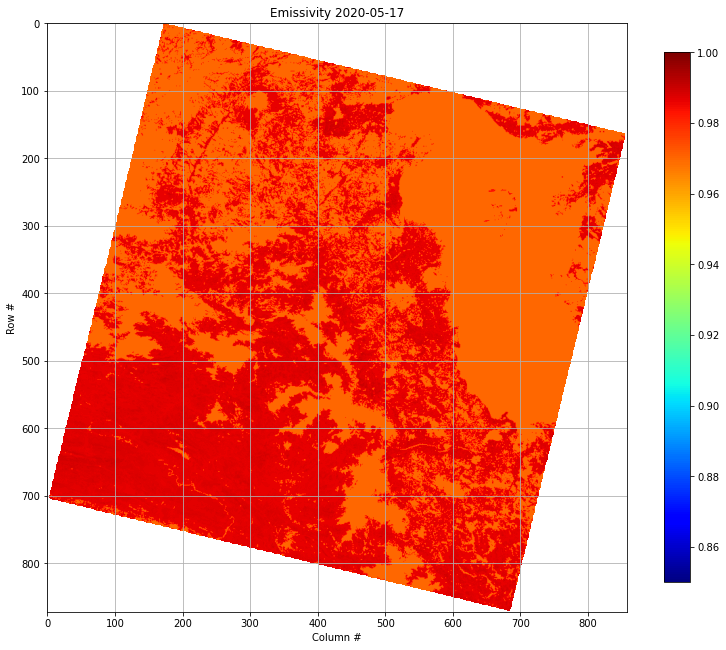

In [12]:
 emm1 = emm1.astype('f4')
 emm1[emm1==0] = np.nan
#############################################
plt.imshow(emm1, cmap='jet')
plt.colorbar(shrink=0.75)
plt.title('Emissivity {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(0.85,1)